
read train & test data from csv file


Best parameters set found on development set:
{'model__C': 1024.0, 'model__epsilon': 1.0, 'model__gamma': 32.0}
C:  RMSE, MAE, R^2 = 6.327, 3.921, 0.974


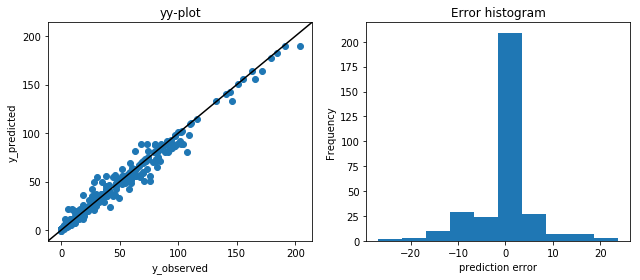

CV: RMSE, MAE, R^2 = 24.969, 15.026, 0.597


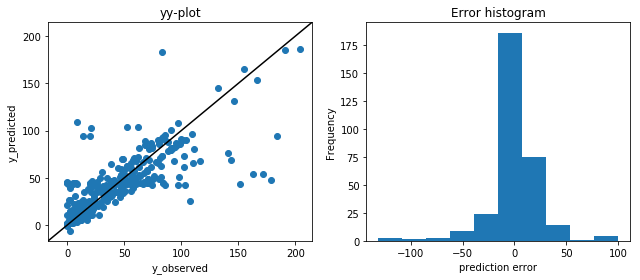

P:  RMSE, MAE, R^2 = 43.557, 43.197, 0.000


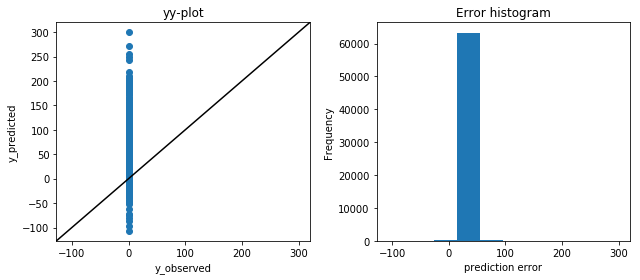


Predicted Tc is written in file test2_Tc_SVM_OCSVM_DCV.csv

Double Cross Validation
In 10 iterations, average +/- standard deviation
RMSE DCV: 29.845 (+/-1.921)
MAE  DCV: 20.144 (+/-0.898)
R^2  DCV: 0.422 (+/-0.075)
391.91 seconds 


In [1]:
# -*- coding: utf-8 -*-
"""
Hydride Tc Regression

1. Hydride Tc Regression (Support Vector Machine)
2. Applicability Domain (One-Class Support Vector Machine)
3. Double Cross Validation

Created on Fri Sep  7 14:35:49 2018

@author: Akitaka

Parameters
----------
Nothing

Returns
-------
Nothing

Input file
----------
tc_train.csv:
    Tc, atomic number 1&2, the number of atoms 1&2, pressure 
    of already calculated materials

tc_test.csv:
    Tc, atomic number 1&2, the number of atoms 1&2, pressure 
    of XnHm (n,m=1,...,10): X=He~At (without rare gas)

Outnput file
------------
test2_Tc_SVR_AD_DCV.csv:
    chemical formula, P, Tc, AD
"""
%matplotlib inline
import pandas as pd
import numpy as np
from time                    import time
from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold
from sklearn.svm             import SVR
from pymatgen                import periodic_table, Composition
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler, MinMaxScaler
from my_library              import print_gscv_score_rgr, dcv_rgr, ad_ocsvm

def read_xy_csv(name): 
    data = np.array(pd.read_csv(filepath_or_buffer=name,
                                index_col=0, header=0, sep=','))[:,:]
    y = data[:,0]
    X = data[:,1:]
    return X, y

start = time()

print()
print('read train & test data from csv file')
print()
train_file = 'tc_train.csv'
X_train, y_train = read_xy_csv(train_file)
test_file = 'tc_test.csv'
X_test, y_test = read_xy_csv(test_file)

# print statistics of database
if(False):
    data = pd.read_csv(filepath_or_buffer='tc_train.csv',
                       index_col=0, header=0, sep=',')
    data.drop('Z2', axis=1, inplace=True)
    print(data.describe())

# range_c = 2**np.arange( -5,  11, dtype=float)
# range_e = 2**np.arange( -10,  1, dtype=float)
# range_g = 2**np.arange( -20, 11, dtype=float)
range_c = 2**np.arange(  -5+10, 11, dtype=float)
range_e = 2**np.arange( -10+5,  1, dtype=float)
range_g = 2**np.arange( -20+25, 11, dtype=float)

# Set the parameters by cross-validation
scaler = MinMaxScaler()
scaler = StandardScaler()
model = SVR()
pipe = Pipeline([('scaler', scaler),('model', model)])
param_grid = [{'model__gamma': range_g, 'model__C': range_c,
               'model__epsilon': range_e}]
n_splits = 5 
cv = ShuffleSplit(n_splits=n_splits, test_size=0.2)
cv = KFold(n_splits=n_splits, shuffle=True)
gscv = GridSearchCV(pipe, param_grid, cv=cv)
gscv.fit(X_train, y_train)
print_gscv_score_rgr(gscv, X_train, X_test, y_train, y_test, cv)

# Prediction
y_pred = gscv.predict(X_test)

# Applicability Domain (inside: +1, outside: -1)
y_appd = ad_ocsvm(X_train, X_test)

data = []
for i in range(len(X_test)):
    satom1 = periodic_table.get_el_sp(int(X_test[i][0])) 
    satom2 = periodic_table.get_el_sp(int(X_test[i][1])) 
    natom1 = int(X_test[i][2])
    natom2 = int(X_test[i][3])
    str_mat = str(satom1) + str(natom1) + str(satom2) + str(natom2)
    formula = Composition(str_mat).reduced_formula
    temp = (formula, int(X_test[i][4]), int(y_pred[i]), y_appd[i])
    data.append(temp)

properties=['formula','P', 'Tc', 'AD']
df = pd.DataFrame(data, columns=properties)
df.sort_values('Tc', ascending=False, inplace=True)

output = 'test2_Tc_SVM_OCSVM_DCV.csv'
# df.to_csv(output, index=False)
df_in_ = df[df.AD ==  1] # df_in_ = df[(df.AD1 ==  1) | (df.AD2 ==  1)]
df_in_.to_csv(output, index=False)
print('Predicted Tc is written in file {}'.format(output))

if(True):
    param_grid = [{'gamma': range_g, 'C': range_c,'epsilon': range_e}]
    dcv_rgr(X_train, y_train, model, param_grid, 10)

print('{:.2f} seconds '.format(time() - start))